In [345]:
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline

# 【問題2】小さな配列でのフォワードプロパゲーションの実験

In [232]:
x = np.array([[[1, 2], [2, 3], [3, 4]]])/100 # (batch_size, n_sequences, n_features)
w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]])/100 # (n_features, n_nodes)
w_h = np.array([[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 8], [4, 6, 8, 10]])/100 # (n_nodes, n_nodes)
batch_size = x.shape[0] # 1
n_sequences = x.shape[1] # 3
n_features = x.shape[2] # 2
n_nodes = w_x.shape[1] # 4
h = np.zeros((batch_size, n_nodes)) # (batch_size, n_nodes)
b = np.array([1, 1, 1, 1]) # (n_nodes,)

In [237]:
def forward(x, w_x, w_h, b):
    h_prev = np.zeros([batch_size, n_sequences+1, n_nodes])
    h_tmp = np.zeros([batch_size, n_sequences, n_nodes])
    h_next = np.zeros([batch_size, n_sequences, n_nodes])
    for t in range(n_sequences):
        h_tmp[:, t, :] = np.dot(x[:,t,:], w_x) + np.dot(h_prev[:,t,:], w_h) + b
        h_next[:, t, :] = np.tanh(h_tmp[:, t, :])
        h_prev[:, t+1, :] = h_next[:, t, :]
    
    return h_next, h_prev

In [239]:
h_next, h_prev = forward(x, w_x, w_h, b)

In [249]:
print(h_next)

[[[0.76188798 0.76213958 0.76239095 0.76255841]
  [0.792209   0.8141834  0.83404912 0.84977719]
  [0.79494228 0.81839002 0.83939649 0.85584174]]]


In [252]:
def backward(X, w_x, w_h, h_prev, dht):
    """
    バックワード
    Parameters
    ----------
    dA : 次の形のndarray, shape (batch_size, n_nodes2)
        後ろから流れてきた勾配
    Returns
    ----------
    dZ : 次の形のndarray, shape (batch_size, n_nodes1)
        前に流す勾配
    """
    dX = np.zeros([*X.shape])
    dh_next = np.zeros([X.shape[0], X.shape[1]+1, w_x.shape[1]])
    for t in reversed(range(X.shape[1])):
        dh = dht[:, t, :] + dh_next[:, t+1, :]
        dB = np.sum(dh, axis=0)
        dWh = np.dot(h_prev[:, t, :].T, dh)
        dh_next[:, t, :] = np.dot(dh, w_h.T)
        dWx = np.dot(X[:, t, :].T, dh)
        dX[:, t, :] = np.dot(dh, w_x.T)

    return dX

In [255]:
backward(x, w_x, w_h, h_prev, np.arange(12).reshape(1, 3, 4))

array([[[0.657394, 0.86843 ],
        [1.3629  , 1.8783  ],
        [1.62    , 2.27    ]]])

# 問題1】SimpleRNNのフォワードプロパゲーション実装

In [416]:
class SimpleRNN:
    """
    Parameters
    ----------
    n_features : int
      分散表現の次数
    n_nodes : int
      outputの次数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_features, n_nodes, initializer, optimizer):
        self.optimizer = optimizer()
        self.Wx = initializer(n_features).init_weight([n_features, n_nodes])
        self.Wh = initializer(n_nodes).init_weight([n_nodes, n_nodes])
        self.B = initializer(n_features).init_bias(n_nodes)
        self.h_prev = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_sequences, n_features)
            入力
        Returns
        ----------
        h_next : 次の形のndarray, shape (batch_size, n_sequences, n_nodes)
                出力
        """
        if self.h_prev is None:
            self.h_prev = np.zeros([X.shape[0], X.shape[1]+1, self.Wx.shape[1]])
        self.h_tmp = np.zeros([X.shape[0], X.shape[1], self.Wx.shape[1]])
        h_next = np.zeros([X.shape[0], X.shape[1], self.Wx.shape[1]])
        for t in range(X.shape[1]):
            self.h_tmp[:, t, :] = np.dot(X[:,t,:], self.Wx) + np.dot(self.h_prev[:,t,:], self.Wh) + self.B
            h_next[:, t, :] = np.tanh(self.h_tmp[:, t, :])
            self.h_prev[:, t+1, :] = h_next[:, t, :]
        
        self.X = X
            
        return h_next
    
    def backward(self, dht):
        """
        バックワード
        Parameters
        ----------
        dht : 次の形のndarray, shape (batch_size, n_sequences, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (batch_size, n_sequences, n_features)
            前に流す勾配
        """
        dX = np.zeros([*self.X.shape])
        dh_next = np.zeros([self.X.shape[0], self.X.shape[1]+1, self.Wx.shape[1]])
        for t in reversed(range(self.X.shape[1])):
            dh = (dht[:, t, :] + dh_next[:, t+1, :])*(1 - (np.tanh(self.h_tmp[:, t, :]))**2)
            self.dB = np.sum(dh, axis=0)
            self.dWh = np.dot(self.h_prev[:, t, :].T, dh)
            dh_next[:, t, :] = np.dot(dh, self.Wh.T)
            self.dWx = np.dot(self.X[:, t, :].T, dh)
            dX[:, t, :] = np.dot(dh, self.Wx.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dX

# 【問題3】（アドバンス課題）バックプロパゲーションの実装

In [174]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [6]:
class XavierInitializer:
    def __init__(self, input_nodes):
        self.sigma = 1/np.sqrt(input_nodes)
        
    def init_weight(self, W_shape):
        W = self.sigma*np.random.randn(*W_shape)
        
        return W
    
    def init_bias(self, output_nodes):
        B = self.sigma*np.random.randn(output_nodes)
        
        return B

In [294]:
class AdaGrad_rnn:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h_Wh = 0
        self.h_Wx = 0
        self.h_B = 0
        
    def update(self, layer):
        self.h_Wh += layer.dWh**2
        self.h_Wx += layer.dWx**2
        self.h_B += layer.dB**2
        layer.Wh -= self.lr*layer.dWh/np.sqrt(self.h_Wh + 1e-7)
        layer.Wx -= self.lr*layer.dWx/np.sqrt(self.h_Wx + 1e-7)
        layer.B -= self.lr*layer.dB/np.sqrt(self.h_B + 1e-7)
        
        return layer

In [295]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h_W = 0
        self.h_B = 0
        
    def update(self, layer):
        self.h_W += layer.dW**2
        self.h_B += layer.dB**2
        layer.W -= self.lr*layer.dW/np.sqrt(self.h_W + 1e-7)
        layer.B -= self.lr*layer.dB/np.sqrt(self.h_B + 1e-7)
        
        return layer

In [8]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = np.tanh(A)
        
        return Z
    
    def backward(self, dZ):
        dA = dZ*(1 - np.tanh(self.A)**2)
        
        return dA

In [167]:
class SigmoidWithLoss:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.sigmoid = 1 / (1 + np.exp(-X))
        
        return self.sigmoid
    
    def backward(self, y):
        loss = -np.sum(y*np.log(self.sigmoid + 1e-7))/y.shape[0]
        dX = self.sigmoid - y
        
        return loss, dX

In [270]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, batch_size, n_nodes, output, initializer, optimizer):
        self.optimizer = optimizer()
        self.W = initializer(n_features*n_nodes).init_weight([n_nodes, output])
        self.B = initializer(n_features*n_nodes).init_bias(output)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        rX = X.reshape(X.shape[0]*X.shape[1], -1)
        out = np.dot(rX, self.W) + self.B
        out = out.reshape(X.shape[0], X.shape[1])
        
        self.X = X
        self.rX = rX
        
        return out
    
    def backward(self, dout):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dout = dout.reshape(self.X.shape[0]*self.X.shape[1], -1)
        self.dB = np.sum(dout, axis=0)
        self.dW = np.dot(self.rX.T, dout)
        dX = np.dot(dout, self.W.T)
        dX = dX.reshape(self.X.shape[0], self.X.shape[1], -1)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dX

In [9]:
from keras.datasets import imdb

Using TensorFlow backend.


In [22]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding

## rnnに入れるデータの形式がわからないのでkerasで見てみる

In [10]:
max_features = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)

C:\Anaconda\lib\site-packages\keras\datasets\imdb.py:49: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


17465344/17464789 [==============================] - 4s 0us/step


In [23]:
print(X_train[0])

[  336   385    39     4   172  4536  1111    17   546    38    13   447
     4   192    50    16     6   147  2025    19    14    22     4  1920
  4613   469     4    22    71    87    12    16    43   530    38    76
    15    13  1247     4    22    17   515    17    12    16   626    18
 19193     5    62   386    12     8   316     8   106     5     4  2223
  5244    16   480    66  3785    33     4   130    12    16    38   619
     5    25   124    51    36   135    48    25  1415    33     6    22
    12   215    28    77    52     5    14   407    16    82 10311     8
     4   107   117  5952    15   256     4     2     7  3766     5   723
    36    71    43   530   476    26   400   317    46     7     4 12118
  1029    13   104    88     4   381    15   297    98    32  2071    56
    26   141     6   194  7486    18     4   226    22    21   134   476
    26   480     5   144    30  5535    18    51    36    28   224    92
    25   104     4   226    65    16    38  1334   

In [21]:
maxlen = 180
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
print(X_train[2])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1   14   47
    8   30   31    7    4  249  108    7    4 5974   54   61  369   13
   71  149   14   22  112    4 2401  311   12   16 3711   33   75   43
 1829  296    4   86  320   35  534   19  263 4821 1301    4 1873   33
   89   78   12   66   16    4  360    7    4   58  316  334   11    4
 1716   43  645  662    8  257   85 1200   42 1228 2578   83   68 3912
   15   36  165 1539  278   36   69    2  780    8  106   14 6905 1338
   18    6   22   12  215   28  610   40    6   87  326   23 2300   21
   23   22   12  272   40   57   31   11    4   22   47    6 2307   51
    9  170   23  595  116  595 1352   13  191   79  638   89    2   14
    9    8  106  607  624   35  534    6  227    7  129  113]


In [24]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=100, input_length=180))
model.compile('rmsprop', 'mse')
sample_array = model.predict(X_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [27]:
print(sample_array)
print(sample_array.shape)

[[[ 1.5207518e-02 -1.8380094e-02 -9.2659593e-03 ... -1.2213148e-02
    4.4777129e-02 -7.8227296e-03]
  [-2.8515672e-02  2.6694026e-02 -3.4365583e-02 ... -3.1015409e-02
    3.0296817e-03  3.7374701e-02]
  [-9.7788572e-03  3.0138467e-02 -1.9144762e-02 ... -7.5105205e-03
    2.8995622e-02 -4.2813636e-02]
  ...
  [ 2.8988410e-02 -3.3657778e-02  1.2687672e-02 ...  3.1035494e-02
   -2.8857101e-02 -4.7386825e-02]
  [-1.0987259e-02  4.5916442e-02  3.4396324e-02 ... -3.8171530e-02
    1.1776589e-02 -4.9350049e-02]
  [ 8.6442009e-03 -4.0998589e-02 -2.2517134e-02 ...  1.0025572e-02
   -1.5979633e-03  5.8827624e-03]]

 [[-4.1684620e-03  7.5774677e-03  4.7578488e-02 ... -2.5565512e-03
   -4.9309324e-02  4.4185821e-02]
  [-7.8665987e-03 -1.7824270e-02 -3.3145964e-02 ...  4.4563416e-02
    5.3800270e-04  1.8598769e-02]
  [ 8.4765069e-03 -2.5460768e-02  2.9667150e-02 ...  2.7624477e-02
    3.7509266e-02 -2.6991773e-02]
  ...
  [-3.4168698e-02  1.6765360e-02 -5.0863028e-03 ...  4.6335075e-02
    8.0504

In [28]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

In [29]:
def separate_words(data):
    data_list = []
    for sentence in data:
        words = re.split('\W+', sentence)
        if words[-1] == '':
            words.remove('')
        words_list = []
        for word in words:
            word = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', word)
            words_list.append(word)
        data_list.append(words_list)
    
    return data_list

In [32]:
X_train = separate_words(x_train)

In [46]:
X_test = separate_words(x_test)

In [47]:
sentences = X_train + X_test
model = Word2Vec(min_count=1, size=100) # 次元数を100に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


(45956965, 59894910)

In [48]:
def to_array(data):
    array_data = []
    for sentence in data:
        array_list = []
        for word in sentence:
            array_list.append(model.wv[word].reshape(1, -1))
        array = np.concatenate(array_list, axis=0)
        array_data.append(array)
    
    return array_data

In [56]:
X_train_array = to_array(X_train)

In [59]:
X_test_array = to_array(X_test)

In [138]:
# maxの語彙数を求める
def max_length(data):
    length = 0
    for i in data:
        length = max(length, i.shape[0])
    
    return length

In [139]:
print(max_length(X_train_array))
print(max_length(X_test_array))

2525
2389


In [140]:
def padding(sentence_vec):
    padding_list = []
    for sentence in sentence_vec:
        while len(sentence) < 200:
            sentence = np.insert(sentence, 0, 0, axis=0)
        padding_list.append(sentence)
    
    return padding_list

In [141]:
X_train_array_padding = padding(X_train_array)

In [142]:
X_test_array_padding = padding(X_test_array)

In [143]:
print(X_train_array_padding[0].shape)
print(X_test_array_padding[0].shape)

(200, 100)
(200, 100)


In [152]:
X_train_time_list = []
for X_array in X_train_array_padding:
    X_train_time_list.append(X_array[-200:])

In [158]:
X_test_time_list = []
for X_array in X_test_array_padding:
    X_test_time_list.append(X_array[-200:])

In [159]:
print(len(X_train_time_list))
print(X_train_time_list[0].shape)
print(len(X_test_time_list))
print(X_test_time_list[0].shape)

25000
(200, 100)
25000
(200, 100)


In [160]:
X_train_time = np.concatenate(X_train_time_list, axis=0).reshape(25000, 200, 100)

In [163]:
X_test_time = np.concatenate(X_test_time_list, axis=0).reshape(25000, 200, 100)

In [434]:
class NN:
    def __init__(self, epoch=10, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['RNN'] = SimpleRNN(100, 50, XavierInitializer, AdaGrad_rnn, )
        self.layers['Affine1'] = FC(20, 50, 1, XavierInitializer, AdaGrad)
        self.last_layer = SigmoidWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                X_batch = np.sum(X_batch, axis=1)
                sigmoid = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                dA = np.tile(dA, X.shape[1])/X.shape[1]
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                sigmoid_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(sigmoid_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        X = np.sum(X, axis=1)
        self.last_layer.forward(X)
        y_pred = self.last_layer.sigmoid
        
        return y_pred

In [435]:
nn = NN()

In [436]:
nn.fit(X_train_time, y_train)

1.9377338278926959
1.4211128624531209
1.299815082238432
1.2273475488457029
1.049520186753718
1.0423172755700243
1.0062245659400597
0.984042748733296
0.9436683066834155
0.9428606765604549


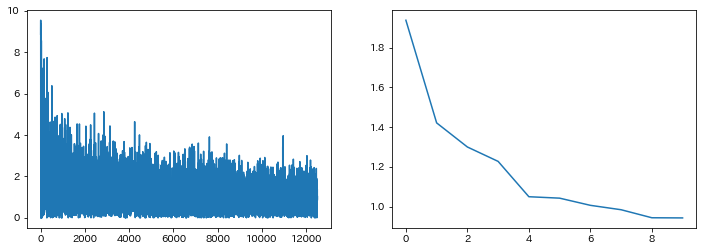

In [437]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(nn.loss_list)
ax[1].plot(nn.loss_epoch_list)
plt.show()

In [438]:
# h_prevがtrain時のバッチサイズを記憶しているため
y_pred_list = []
for i in range(1250):
    y_pred = nn.predict(X_test_time[i*20:(i+1)*20])
    y_pred_list.append(y_pred)
y_pred = np.concatenate(y_pred_list, axis=0)

In [439]:
print(y_pred)
print(y_test)

[9.48970747e-01 4.59971910e-03 8.65229629e-03 ... 4.71928047e-03
 1.90826697e-05 9.15294403e-02]
[1 0 1 ... 0 0 0]


In [440]:
y_pred = np.where(y_pred>=0.5, 1, 0)
print(y_pred)

[1 0 0 ... 0 0 0]


In [441]:
accuracy_score(y_test, y_pred)

0.58616

## 動きはしたが、スコアは悪かった。